In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
# os.chdir('..')
# os.getcwd()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import multivariate_normal


In [3]:
def binary_gaussian(
    mean_0, mean_1, cov_0, cov_1, prior_prob_1, N_SAMPLES=1000, seed=42
):
    N_1 = np.random.binomial(N_SAMPLES, p=prior_prob_1)
    N_0 = N_SAMPLES - N_1

    X_0 = np.random.multivariate_normal(mean_0, cov_0, size=N_0)
    X_1 = np.random.multivariate_normal(mean_1, cov_1, size=N_1)
    X = np.vstack((X_0, X_1))
    y = np.ones((N_SAMPLES))
    y[:N_0] = 0
    return X, y

# https://www.color-hex.com/
pos_scatter_clr = '#79B9E1' # dark skyblue
neg_scatter_clr = 'lightcoral'
third_scatter_clr = '#000000'
def scatter2d(ax,data,label=None, data_name='data',show_axis_name=True,**kwargs):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()

    if label is None:
        ax.scatter(data[:,0], data[:,1], label=data_name, **kwargs)
    else:
        if isinstance(label, torch.Tensor):
            label = label.cpu().numpy()
        data_0 = data[label == 0]
        data_1 = data[label == 1]
        data_2 = data[label == -1]

        ax.scatter(data_0[:,0], data_0[:,1], label=f"{data_name} - class 0", **kwargs, color=neg_scatter_clr)
        ax.scatter(data_1[:,0], data_1[:,1], label=f"{data_name} - class 1", **kwargs, color=pos_scatter_clr)
        ax.scatter(data_2[:,0], data_2[:,1], label=f"{data_name} - class -1", **kwargs, color=third_scatter_clr)
    if show_axis_name:
        ax.set_ylabel(r"$x_2$")
        ax.set_xlabel(r"$x_1$")
    # ax.legend()

# https://www.color-hex.com/
pos_surface_clr = 'LightSkyBlue'
neg_surface_clr = '#f4a6a6'
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html
@torch.no_grad()
def viz_clf(ax,model, data=None, label=None, DEVICE=torch.device('cpu'), hard=False,
            bound_x=(0,1), bound_y=(0,1), step=0.001, pad=0.05, auto_bound=True, contour=False, **kwargs):

    if data is not None:
        scatter2d(ax,data,label,**kwargs)

    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    if auto_bound:
        bound_x = ax.get_xlim()
        bound_y = ax.get_ylim()
        bound_sq = (min(bound_x[0], bound_y[0]),max(bound_x[1], bound_y[1]))
        bound_x = bound_sq
        bound_y = bound_sq
    # pad the bounds for better plots
    bound_x=(bound_x[0]-pad,bound_x[1]+pad)
    bound_y=(bound_y[0]-pad,bound_y[1]+pad)

    c0 = torch.Tensor(to_rgba(neg_surface_clr)).to(DEVICE)
    c1 = torch.Tensor(to_rgba(pos_surface_clr)).to(DEVICE)
    x1 = torch.arange(*bound_x, step=step, device=DEVICE)
    x2 = torch.arange(*bound_y, step=step, device=DEVICE)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='xy')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    leng = model_inputs.shape[0]
    width = model_inputs.shape[1]

    # checks if the model is an instance of sklearn classifiers, not ideal
    sk_clf = "sklearn" in str(model.__class__)

    if sk_clf:
        if hard:# hax
            preds = torch.from_numpy(model.predict(model_inputs.reshape(-1,2)).reshape(leng,width,-1))
        else:
            preds = torch.from_numpy(model.predict_proba(model_inputs.reshape(-1,2))[:,1].reshape(leng,width,-1))
    else:
        model.to(DEVICE)
        model.eval()
        if hard:
            preds = 1.0*(model(model_inputs) > 0.5)
        else:
            preds = model(model_inputs)

    if contour:
        if  isinstance(xx1, torch.Tensor):
            xx1 = xx1.cpu().numpy()
            xx2 = xx2.cpu().numpy()
            preds = preds.cpu().numpy()
            preds = preds.squeeze()

        ax.contour(xx1, xx2, preds, levels=[0.5], colors='k', linestyles='--',**kwargs)
        ax.set_xlim(bound_x)
        ax.set_ylim(bound_y)
    else:
        output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
        if  isinstance(output_image, torch.Tensor):
            output_image = output_image.cpu().numpy()
        ax.imshow(output_image, origin='lower', extent=(*bound_x,*bound_y), alpha=0.6)

<ipython-input-3-75d16517b0bb>:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_0 = np.random.multivariate_normal(mean_0, cov_0, size=N_0)


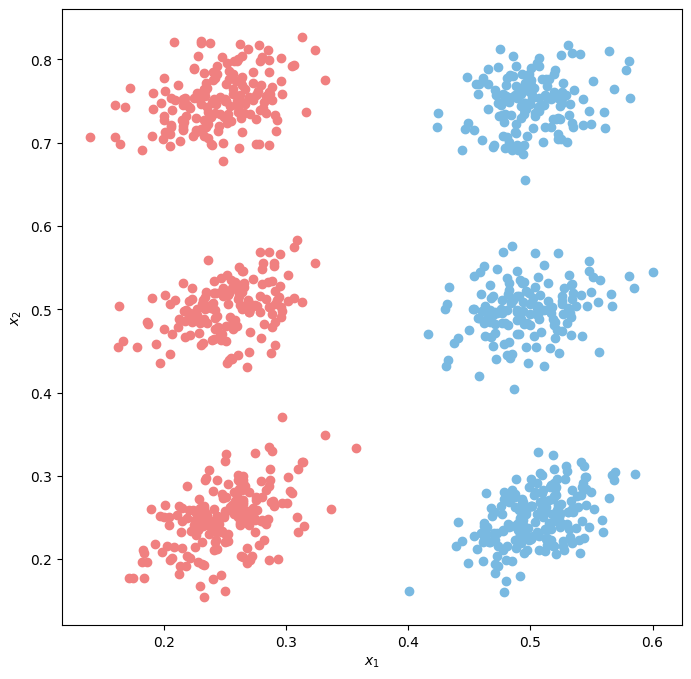

In [51]:
N_SAMPLES = 1000

SOURCE_DOMAINS = [0,2]
TEST_DOMAINS = [1]

DOMAIN_PRIORS = [0.4,0.3,0.3]
SOURCE_PRIOR = 0
for i in SOURCE_DOMAINS:
  SOURCE_PRIOR += DOMAIN_PRIORS[i]
DOMAIN_PRIOR_1 = [0.5,0.5,0.5]

domain_labels = np.random.choice(np.arange(len(DOMAIN_PRIORS)), p=DOMAIN_PRIORS, size=N_SAMPLES)

# DOMAIN_MEAN_0 = [np.array([1, 1]),np.array([-1, 3])]
# DOMAIN_MEAN_1 = [np.array([-1, -1]),np.array([1, -3])]

DOMAIN_MEAN_0 = [np.array([0.25, 0.25]),np.array([0.25, 0.50]),np.array([0.25, 0.75])]
DOMAIN_MEAN_1 = [np.array([0.50, 0.25]),np.array([0.50, 0.50]),np.array([0.50, 0.75])]


alpha = 0.001
DOMAIN_COV_0 = [alpha*np.array([[1, 0.6], [0.4, 1]]), alpha*np.array([[1, 0.35], [0.25, 1]]), alpha*np.array([[1, 0.3], [0.3, 1]])]
DOMAIN_COV_1 = [alpha*np.array([[1, 0.5], [0.5, 1]]), alpha*np.array([[1, 0.3], [0.3, 1]]), alpha*np.array([[1, 0.3], [0.3, 1]])]

train_X = []
train_y = []
test_X = []
test_y = []
for i in SOURCE_DOMAINS:

    PRIOR_1 = DOMAIN_PRIOR_1[i]
    mean_0 = DOMAIN_MEAN_0[i]
    mean_1 = DOMAIN_MEAN_1[i]
    cov_0 = DOMAIN_COV_0[i]
    cov_1 = DOMAIN_COV_1[i]

    X, y = binary_gaussian(mean_0, mean_1, cov_0, cov_1, prior_prob_1=PRIOR_1, N_SAMPLES=(domain_labels==i).sum())
    train_X.append(X)
    train_y.append(y)

for i in TEST_DOMAINS:

    PRIOR_1 = DOMAIN_PRIOR_1[i]
    mean_0 = DOMAIN_MEAN_0[i]
    mean_1 = DOMAIN_MEAN_1[i]
    cov_0 = DOMAIN_COV_0[i]
    cov_1 = DOMAIN_COV_1[i]

    X, y = binary_gaussian(mean_0, mean_1, cov_0, cov_1, prior_prob_1=PRIOR_1, N_SAMPLES=(domain_labels==i).sum())
    test_X.append(X)
    test_y.append(y)

train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)
test_X = np.concatenate(test_X)
test_y = np.concatenate(test_y)

X = np.concatenate([train_X, test_X])
y = np.concatenate([train_y, test_y])

fig, ax = plt.subplots(figsize=(8,8))
scatter2d(ax,X,y)

In [40]:
clf = MLPClassifier(hidden_layer_sizes=[10,10],random_state=42, max_iter=1000).fit(train_X, train_y)

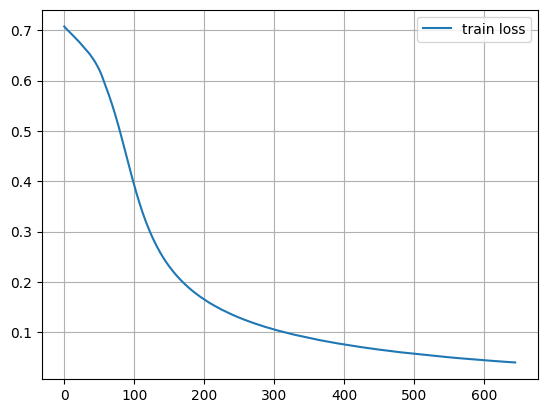

In [41]:
fig, ax = plt.subplots()
ax.plot(clf.loss_curve_, label='train loss')
ax.grid()
ax.legend()

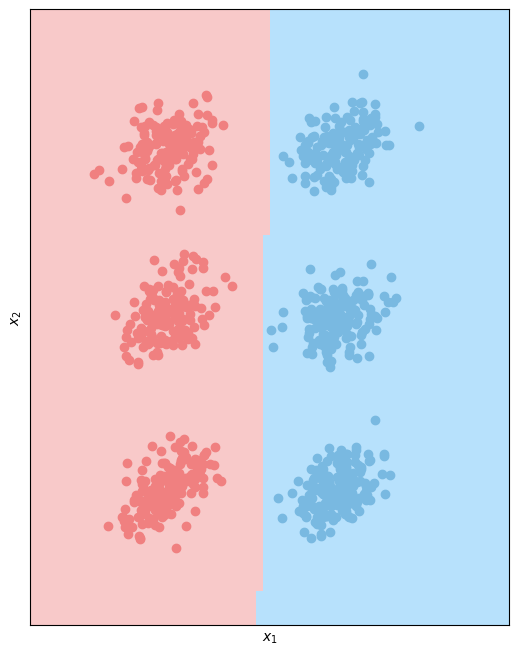

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
viz_clf(ax, clf, X,y, hard=True, step=0.01, auto_bound=False, bound_x = (0.1,0.7), bound_y=(0.1,0.9))
# , bound_x=(-2,2), bound_y=(-4,4), auto_bound=False

In [47]:
def bayesfunc(x1,x2,eps):
    # pos_prob = 0.5
    # mx_prob = 0.1
    # f= np.array([[0.005,0],[0,0.005]])
    # g= np.array([[0.00,0.004],[0.004,0.00]])

    # pos_density = DOMAIN_PRIORS[0]*multivariate_normal(mean=DOMAIN_MEAN_1[0], cov=DOMAIN_COV_1[0]).pdf([x1,x2])
    # neg_density = DOMAIN_PRIORS[0]*multivariate_normal(mean=DOMAIN_MEAN_0[0], cov=DOMAIN_COV_0[0]).pdf([x1,x2])
    # pos_prob = DOMAIN_PRIORS[0]*DOMAIN_PRIOR_1[0]

    pos_density = 0
    neg_density = 0
    pos_prod = 0
    for i in SOURCE_DOMAINS:
        pos_density += (DOMAIN_PRIORS[i]/SOURCE_PRIOR)*multivariate_normal(mean=DOMAIN_MEAN_1[i], cov=DOMAIN_COV_1[i]).pdf([x1,x2])
        neg_density += (DOMAIN_PRIORS[i]/SOURCE_PRIOR)*multivariate_normal(mean=DOMAIN_MEAN_0[i], cov=DOMAIN_COV_0[i]).pdf([x1,x2])
        pos_prob = DOMAIN_PRIORS[i]*DOMAIN_PRIOR_1[i]


    return (pos_prob*(eps+pos_density))/(eps + pos_prob*pos_density + (1 - pos_prob)*neg_density)

In [48]:
class sklearnBayesOptClf(object):
    # name sklearn is important to fool viz clf function
    # assumes that func accepts an argument eps to use
    def __init__(self, eps, func, denorm=None):
        self.eps = eps # if data density is exactly zero, eps is considered and classifier 'snaps back to prior'
        self.raw_func = np.vectorize(func)
        if denorm == None:
            self.denorm = lambda x:x
        else:
            self.denorm = denorm

    def __call__(self, x):
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
        x = self.denorm(x)
        x1 = x[:,0]
        x2 = x[:,1]
        # should return probabilities of each class
        return self.raw_func(x1,x2,self.eps)

    def predict_proba(self,x):
        forward_pos = self(x)
        forward_neg = 1 - forward_pos

        return np.stack([forward_neg, forward_pos]).T

    def predict(self,x):
        return (self.predict_proba(x)[:,1]>0.5)*1.0

In [52]:
dummy_model = sklearnBayesOptClf(1e-12,bayesfunc)

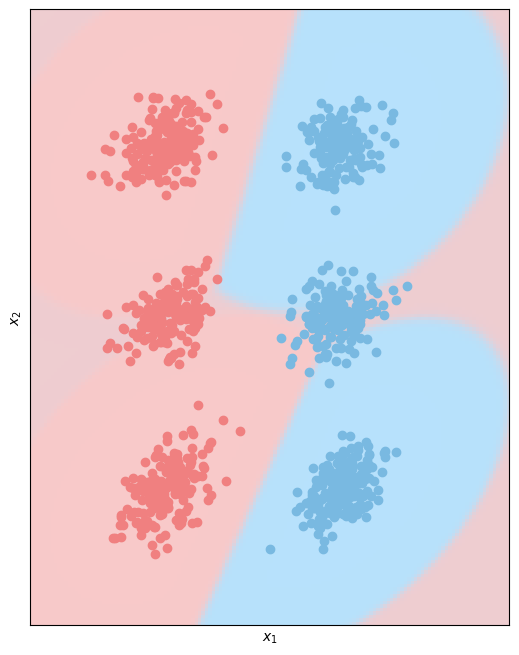

In [53]:
fig, ax = plt.subplots(figsize=(8,8))
viz_clf(ax, dummy_model, X, y, step=0.005, bound_x = (0.1,0.7), bound_y=(0.1,0.9), auto_bound=False)